In [3]:
%matplotlib inline
import utils
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
import librosa
import librosa.display
import missingno as msno 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler, RobustScaler
# importing warning in order to ignore them
import warnings 
warnings.filterwarnings('always')   #suppresses all warnings
warnings.filterwarnings('ignore')

In [4]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

tracks= utils.load('C:/Users/giuli/Desktop/DM2 PROGETTO/file/tracks.csv')
genres= utils.load('C:/Users/giuli/Desktop/DM2 PROGETTO/file/genres.csv')
features= utils.load('C:/Users/giuli/Desktop/DM2 PROGETTO/file/features.csv')
echonest= utils.load('C:/Users/giuli/Desktop/DM2 PROGETTO/file/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [5]:
tracks_cut=['album','artist']
tracks.drop(tracks_cut,axis=1,inplace=True)
tracks.shape

(106574, 22)

In [6]:
tracks=tracks.droplevel(0,axis=1)

In [7]:
tracks_cut=['composer','comments', 'date_created','date_recorded',
            'license','number','title','language_code',
            'publisher', 'tags','information','lyricist','genres','genres_all',
            'favorites','listens','interest','bit_rate', 'duration']
tracks.drop(tracks_cut,axis=1,inplace=True)

In [8]:
df_target=features[['spectral_rolloff','spectral_centroid']]

In [9]:
df_target=df_target.droplevel(0,axis=1)

In [10]:
df_target.columns=['roll_kurtosis','roll_max','roll_mean','roll_median','roll_min','roll_skew','roll_std',
                   'centr_kurtosis','centr_max','centr_mean','centr_median','centr_min','centr_skew','centr_std']
                   
                   #'bandw_kurtosis','bandw_max','bandw_mean','bandw_median','bandw_min','bandw_skew','bandw_std']
df_target.head()

,roll_kurtosis,roll_max,roll_mean,roll_median,roll_min,roll_skew,roll_std,centr_kurtosis,centr_max,centr_mean,centr_median,centr_min,centr_skew,centr_std
track_id,,,,,,,,,,,,,,
2,0.840540,9410.009766,3267.804688,3143.847656,0.000000,0.347372,1300.729736,2.406808,5514.049805,1639.583252,1503.496704,0.000000,1.079815,719.770508
3,2.379145,10002.172852,3514.619629,3413.012695,0.000000,1.118952,1650.357788,3.519866,6288.426758,1763.012451,1517.993652,0.000000,1.652693,972.758423
5,-0.238572,9442.309570,2773.931885,2863.916016,0.000000,0.266975,1323.465210,1.322586,5648.614746,1292.958130,1186.514038,0.000000,0.937101,665.319275
10,3.619834,10056.005859,2603.491943,2002.587891,0.000000,1.800220,1524.401245,9.729688,5739.394531,1360.028687,1180.966797,0.000000,2.523783,668.700806
20,-0.744805,9496.142578,4201.346191,4166.674805,75.366211,0.160345,1495.297119,2.177669,5540.209961,1732.971802,1640.781128,123.611168,0.960959,481.929871


In [11]:
df=pd.merge(tracks,df_target, on='track_id')

In [12]:
df.drop(index=df[df.subset=='large'].index, inplace=True)

# Pre-processing

In [13]:
train = df.index[df['split'] == 'training']
val = df.index[df['split'] == 'validation']
test = df.index[df['split'] == 'test']

In [14]:
#copy dataframe
df_enc=df.copy()

In [15]:
le=LabelEncoder()
ple= preprocessing.LabelEncoder()
df_enc['genre_top']=le.fit_transform(df_enc['genre_top'])

In [16]:
df_enc['genre_top'].unique()

array([ 7, 12, 13,  6,  5, 10,  4,  9, 14,  0, 15,  2,  1, 11,  8,  3])

In [17]:
replace_values=[ 7, 12, 13,  6,  5, 10,  4,  9, 14,  0, 15,  2,  1,  8,  3]
df_enc['genre_top']=df_enc['genre_top'].replace(replace_values,0)
df_enc['genre_top']=df_enc['genre_top'].replace(11,1)

In [18]:
y_train = df_enc['genre_top'].loc[df_enc['split'] == 'training']
y_val = df_enc['genre_top'].loc[df_enc['split'] == 'validation']
y_test = df_enc['genre_top'].loc[df_enc['split'] == 'test']
y_train.shape, y_val.shape, y_test.shape

((19922,), (2505,), (2573,))

In [19]:
X=df_enc.drop('genre_top',axis=1)

In [20]:
X_train = X.loc[X['split'] == 'training']
X_val = X.loc[X['split'] == 'validation']
X_test = X.loc[X['split'] == 'test']
X_train.shape, X_val.shape, X_test.shape

((19922, 16), (2505, 16), (2573, 16))

In [21]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [22]:
cut_columns=['split','subset',]#'genres_all'
X_train.drop(cut_columns,axis=1,inplace=True)
X_val.drop(cut_columns,axis=1,inplace=True)
X_test.drop(cut_columns,axis=1,inplace=True)

In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
#normalize data with Robust scaler
scaler = RobustScaler()
scaler.fit_transform(X_train)
scaler.fit_transform(X_val)
scaler.fit_transform(X_test)

array([[ 1.39836398, -0.4047619 ,  0.12139229, ..., -0.48737327,
         0.42965552, -0.36366488],
       [ 0.03145794, -1.        , -0.30757461, ...,  0.3435532 ,
        -0.32662998, -0.80959978],
       [ 0.47839267,  1.33333333, -0.38022626, ..., -0.48737327,
         0.85467611,  0.47919876],
       ...,
       [-0.26400148,  0.66666667,  0.75783894, ...,  0.03345448,
        -0.0669875 ,  2.09023863],
       [ 0.98246302,  0.73809524, -0.52915618, ..., -0.2470687 ,
         1.59824388,  0.83670523],
       [-0.25908031,  0.66666667,  0.37986337, ...,  0.73607752,
         0.01492147,  2.75243267]])

In [24]:
#task:rimuovere l'1% degli outliers:
outlier_fraction = 0.1
#andremo a cercare slamente l'1% degli outliers e li rimuoveremo o sostituiremo in seguito

In [25]:
from pyod.models.abod import ABOD

In [26]:
abod=ABOD(contamination=outlier_fraction)
abod.fit(X_train)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [27]:
abod_anomalies = abod.predict(X_train)
np.unique(abod_anomalies, return_counts=True)

(array([0, 1]), array([17666,  2256], dtype=int64))

In [28]:
# select all rows that are not outliers
abod_inlier= abod_anomalies!=1
abod_outliers= X_train[abod_anomalies==1]
X_train.shape

(19922, 14)

In [29]:
# select all rows that are not outliers
abod_inlier= abod_anomalies!=1
abod_outlier= X_train[abod_anomalies==1]
X_train1, y_train1 = X_train.iloc[abod_inlier, :], y_train.iloc[abod_inlier]
# summarize the shape of the updated training dataset
print(X_train1.shape, y_train1.shape)

(17666, 14) (17666,)


In [30]:
from sklearn.ensemble import IsolationForest

In [31]:
iso = IsolationForest(max_samples=100,random_state=42, contamination=0.1) 
iso.fit(X_train)
if_anomalies=iso.predict(X_train)

In [32]:
np.unique(if_anomalies,return_counts=True)

(array([-1,  1]), array([ 1993, 17929], dtype=int64))

In [33]:
# select all rows that are not outliers
if_inlier=if_anomalies!=-1
if_outlier=X_train[if_anomalies==-1]
X_train4, y_train4 = X_train.iloc[if_inlier, :], y_train.iloc[if_inlier]
# summarize the shape of the updated training dataset
print(X_train4.shape, y_train4.shape)

(17929, 14) (17929,)


# COMPARISONS

In [34]:
if_indexes=if_outlier.index.tolist()
abod_indexes=abod_outlier.index.tolist()

In [35]:
#comparison if with abod
count_if_abod=0
for i in set(if_indexes).intersection(set(abod_indexes)):
    count_if_abod= count_if_abod+1
print(count_if_abod) 

743


In [36]:
X_train_clean=X_train.copy()
y_train_clean=y_train.copy()

In [37]:
for index in set(if_indexes).intersection(set(abod_indexes)):
    X_train_clean.drop(index,inplace=True)
    y_train_clean.drop(index, inplace=True)
print('Dataset before outliers removed:',X_train.shape, y_train.shape)
print('Dataset cleaned:', X_train_clean.shape, y_train_clean.shape)

Dataset before outliers removed: (19922, 14) (19922,)
Dataset cleaned: (19179, 14) (19179,)


In [38]:
X_train=X_train_clean
y_train=y_train_clean
X_train.shape,y_train.shape

((19179, 14), (19179,))

In [39]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# Normalizzazione

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Percepton

In [44]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [43]:
clf = MLPClassifier(random_state=0)

clf.fit(X_train, y_train)



MLPClassifier(random_state=0)

In [44]:
y_pred = clf.predict(X_test)

In [45]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9922269724057521
F1-score [0.99602859 0.81818182]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2522
           1       0.76      0.88      0.82        51

    accuracy                           0.99      2573
   macro avg       0.88      0.94      0.91      2573
weighted avg       0.99      0.99      0.99      2573



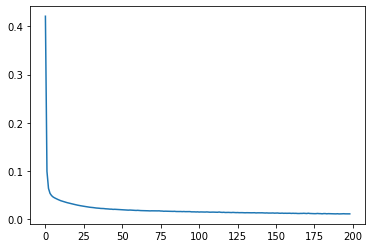

In [46]:
plt.plot(clf.loss_curve_)
plt.show()

In [47]:
clf = MLPClassifier(hidden_layer_sizes=(6, 12, 24), alpha=0.1, learning_rate='adaptive', 
                    activation='relu', early_stopping=True, momentum=0.250, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9887291099883404
F1-score [0.99425173 0.71287129]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2522
           1       0.72      0.71      0.71        51

    accuracy                           0.99      2573
   macro avg       0.86      0.85      0.85      2573
weighted avg       0.99      0.99      0.99      2573



In [48]:
fpr_a,tpr_a,_=roc_curve(y_test,y_pred)
roc_auc_a=auc(fpr_a,tpr_a)
print(roc_auc_a)

0.8501656015300649


[[2508   14]
 [  15   36]]


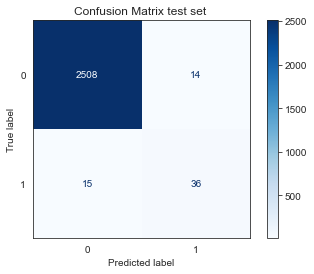

In [49]:
from sklearn.metrics import plot_confusion_matrix
sns.set_style('white')

disp = plot_confusion_matrix(clf,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test set ')
print(disp.confusion_matrix)
plt.show()

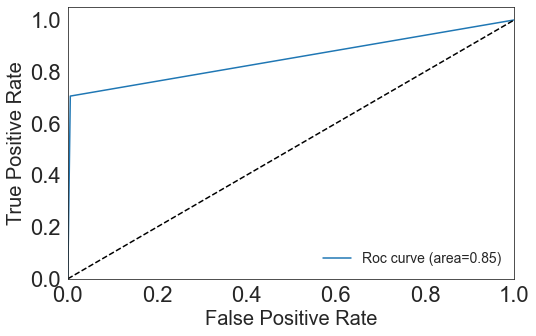

In [50]:
plt.figure(figsize=(8,5))
plt.plot(fpr_a,tpr_a,label='Roc curve (area=%0.2f)'%(roc_auc_a))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

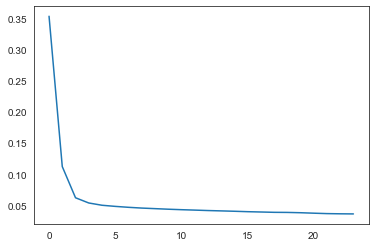

In [51]:
plt.plot(clf.loss_curve_)
plt.show()

In [45]:
from sklearn import neural_network
from sklearn.model_selection import GridSearchCV

In [53]:
#vedendo i risultati di classificatori precedenti ci siamo resi conto del fatto che i dati sono linearly separable
#IN TAL CASO ABBIAMO PREFERITO USARE UNA RELU 'CHE IN PROGETTI PRECEDENTI DI ML CI HA DATO RISULTATI MOLTO  BUONI'

In [54]:
parameters = {'solver': ['lbfgs'], 'activation':['relu'], 'hidden_layer_sizes':np.arange(36, 68), 'alpha': 10.0 **-np.arange(0, 1) , 'learning_rate':['adaptive']}
clf_grid = GridSearchCV(neural_network.MLPClassifier(), parameters, n_jobs=-1)

In [55]:
clf_grid.fit(X_train, y_train.values.ravel())
print("-----------------Original Features--------------------")
print("Best score: %0.4f" % clf_grid.best_score_)
print("Using the following parameters:")
print(clf_grid.best_params_)


-----------------Original Features--------------------
Best score: 0.9945
Using the following parameters:
{'activation': 'relu', 'alpha': 1.0, 'hidden_layer_sizes': 43, 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


In [56]:
y_pred_grid = clf_grid.predict(X_test)

In [57]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_grid))
print('F1-score %s' % f1_score(y_test,y_pred_grid, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9914496696463272
F1-score [0.99562972 0.80357143]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2522
           1       0.72      0.71      0.71        51

    accuracy                           0.99      2573
   macro avg       0.86      0.85      0.85      2573
weighted avg       0.99      0.99      0.99      2573



In [58]:
fpr_b,tpr_b,_=roc_curve(y_test,y_pred_grid)
roc_auc_b=auc(fpr_b,tpr_b)
print(roc_auc_b)

0.9380043849419228


[[2506   16]
 [   6   45]]


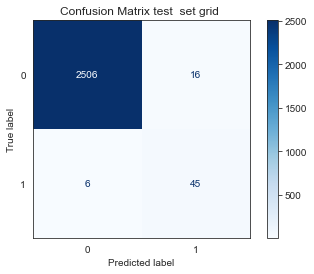

In [59]:
from sklearn.metrics import plot_confusion_matrix
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test  set grid ')
print(disp.confusion_matrix)
plt.show()

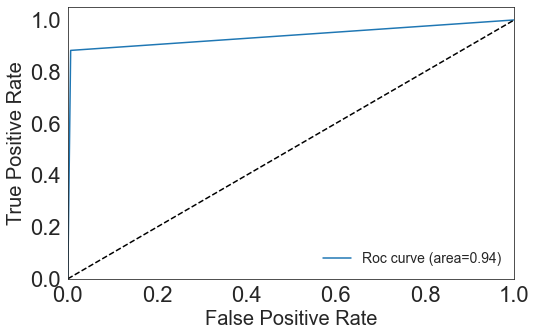

In [60]:
plt.figure(figsize=(8,5))
plt.plot(fpr_b,tpr_b,label='Roc curve (area=%0.2f)'%(roc_auc_b))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [61]:
parameters_2= {'solver': ['sgd'], 'activation':['relu'], 'hidden_layer_sizes':np.arange(36, 68), 'alpha': 10.0 **-np.arange(0, 1) , 'learning_rate':['adaptive']}
clf_grid_2 = GridSearchCV(neural_network.MLPClassifier(), parameters_2, n_jobs=-1)

In [62]:
clf_grid_2.fit(X_train, y_train.values.ravel())
print("-----------------Original Features--------------------")
print("Best score: %0.4f" % clf_grid_2.best_score_)
print("Using the following parameters:")
print(clf_grid_2.best_params_)

-----------------Original Features--------------------
Best score: 0.9893
Using the following parameters:
{'activation': 'relu', 'alpha': 1.0, 'hidden_layer_sizes': 40, 'learning_rate': 'adaptive', 'solver': 'sgd'}


In [63]:
y_pred_grid_2 = clf_grid_2.predict(X_test)

In [64]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_grid_2))
print('F1-score %s' % f1_score(y_test,y_pred_grid_2, average=None))
print(classification_report(y_test, y_pred_grid_2))

Accuracy 0.9891177613680529
F1-score [0.9944664 0.6744186]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2522
           1       0.83      0.57      0.67        51

    accuracy                           0.99      2573
   macro avg       0.91      0.78      0.83      2573
weighted avg       0.99      0.99      0.99      2573



In [65]:
fpr_c,tpr_c,_=roc_curve(y_test,y_pred_grid_2)
roc_auc_c=auc(fpr_c,tpr_c)
print(roc_auc_c)

0.7831241933728289


[[2516    6]
 [  22   29]]


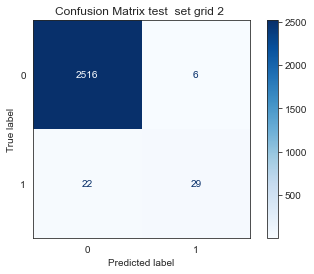

In [66]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_2,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test  set grid 2 ')
print(disp.confusion_matrix)
plt.show()

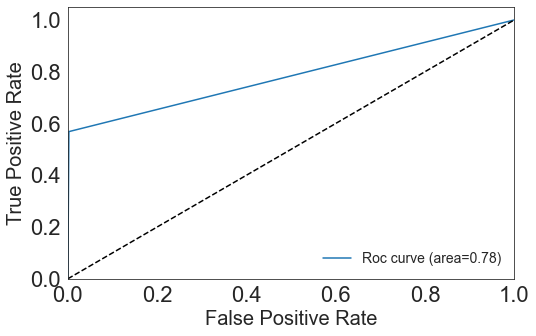

In [67]:
plt.figure(figsize=(8,5))
plt.plot(fpr_c,tpr_c,label='Roc curve (area=%0.2f)'%(roc_auc_c))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [68]:
parameters_3= {'solver': ['adam'], 'activation':['relu'], 'hidden_layer_sizes':np.arange(36, 68), 'alpha': 10.0 **-np.arange(0, 1) , 'learning_rate':['adaptive']}
clf_grid_3 = GridSearchCV(neural_network.MLPClassifier(), parameters_3, n_jobs=-1)

In [69]:
clf_grid_3.fit(X_train, y_train.values.ravel())
print("-----------------Original Features--------------------")
print("Best score: %0.4f" % clf_grid_3.best_score_)
print("Using the following parameters:")
print(clf_grid_3.best_params_)

-----------------Original Features--------------------
Best score: 0.9897
Using the following parameters:
{'activation': 'relu', 'alpha': 1.0, 'hidden_layer_sizes': 45, 'learning_rate': 'adaptive', 'solver': 'adam'}


In [70]:
y_pred_grid_3 = clf_grid_3.predict(X_test)

In [71]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_grid_3))
print('F1-score %s' % f1_score(y_test,y_pred_grid_3, average=None))
print(classification_report(y_test, y_pred_grid_3))

Accuracy 0.9887291099883404
F1-score [0.99427217 0.65060241]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2522
           1       0.84      0.53      0.65        51

    accuracy                           0.99      2573
   macro avg       0.92      0.76      0.82      2573
weighted avg       0.99      0.99      0.99      2573



In [72]:
fpr_d,tpr_d,_=roc_curve(y_test,y_pred_grid_3)
roc_auc_d=auc(fpr_d,tpr_d)
print(roc_auc_d)

0.7637146055884685


[[2517    5]
 [  24   27]]


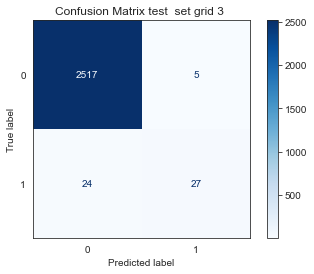

In [73]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_3,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test  set grid 3 ')
print(disp.confusion_matrix)
plt.show()

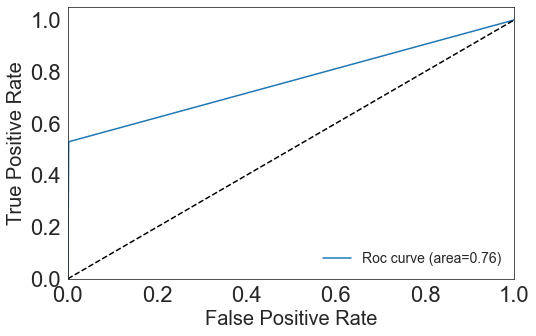

In [74]:
plt.figure(figsize=(8,5))
plt.plot(fpr_d,tpr_d,label='Roc curve (area=%0.2f)'%(roc_auc_d))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

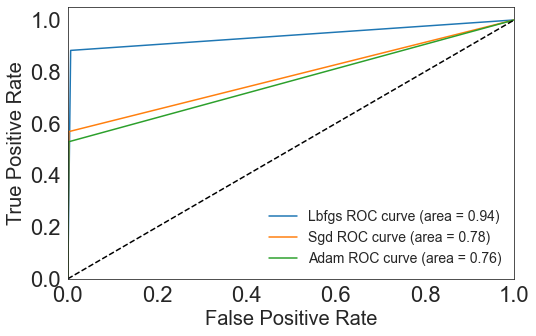

In [100]:
plt.figure(figsize=(8, 5))
plt.plot(fpr_b, tpr_b, label='Lbfgs ROC curve (area = %0.2f)' % (roc_auc_b))
plt.plot(fpr_c, tpr_c, label='Sgd ROC curve (area = %0.2f)' % (roc_auc_c))
plt.plot(fpr_d, tpr_d, label='Adam ROC curve (area = %0.2f)' % (roc_auc_d))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

# cambiamo activation function

In [76]:
parameters_ide = {'solver': ['lbfgs'], 'activation':['identity'], 'hidden_layer_sizes':np.arange(36, 68), 'alpha': 10.0 **-np.arange(0, 1) , 'learning_rate':['adaptive']}
clf_grid_ide = GridSearchCV(neural_network.MLPClassifier(), parameters_ide, n_jobs=-1)


In [77]:
clf_grid_ide.fit(X_train, y_train.values.ravel())
print("-----------------Original Features--------------------")
print("Best score: %0.4f" % clf_grid_ide.best_score_)
print("Using the following parameters:")
print(clf_grid_ide.best_params_)

-----------------Original Features--------------------
Best score: 0.9900
Using the following parameters:
{'activation': 'identity', 'alpha': 1.0, 'hidden_layer_sizes': 51, 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


In [78]:
y_pred_grid_ide = clf_grid_ide.predict(X_test)

In [79]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_grid_ide))
print('F1-score %s' % f1_score(y_test,y_pred_grid_ide, average=None))
print(classification_report(y_test, y_pred_grid_ide))

Accuracy 0.9914496696463272
F1-score [0.99564356 0.77083333]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2522
           1       0.82      0.73      0.77        51

    accuracy                           0.99      2573
   macro avg       0.91      0.86      0.88      2573
weighted avg       0.99      0.99      0.99      2573



In [80]:
fpr_e,tpr_e,_=roc_curve(y_test,y_pred_grid_ide)
roc_auc_e=auc(fpr_e,tpr_e)
print(roc_auc_e)

0.8611590552160595


[[2514    8]
 [  14   37]]


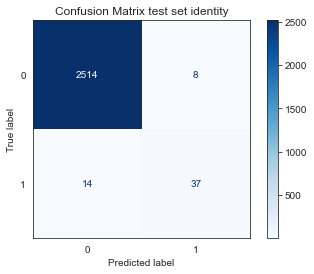

In [81]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_ide,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test set identity')
print(disp.confusion_matrix)
plt.show()

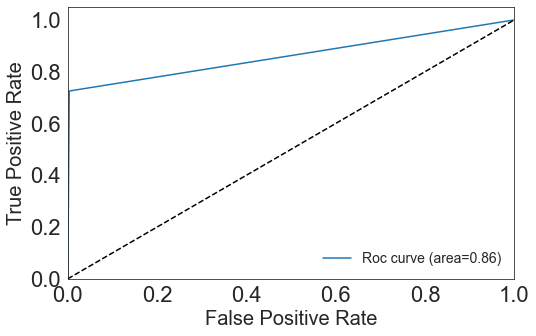

In [82]:
plt.figure(figsize=(8,5))
plt.plot(fpr_e,tpr_e,label='Roc curve (area=%0.2f)'%(roc_auc_e))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [83]:
parameters_log = {'solver': ['lbfgs'], 'activation':['logistic'], 'hidden_layer_sizes':np.arange(36, 68), 'alpha': 10.0 **-np.arange(0, 1) , 'learning_rate':['adaptive']}
clf_grid_log = GridSearchCV(neural_network.MLPClassifier(), parameters_log, n_jobs=-1)


In [84]:
clf_grid_log.fit(X_train, y_train.values.ravel())
print("-----------------Original Features--------------------")
print("Best score: %0.4f" % clf_grid_log.best_score_)
print("Using the following parameters:")
print(clf_grid_log.best_params_)

-----------------Original Features--------------------
Best score: 0.9938
Using the following parameters:
{'activation': 'logistic', 'alpha': 1.0, 'hidden_layer_sizes': 55, 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


In [85]:
y_pred_grid_log = clf_grid_log.predict(X_test)

In [86]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_grid_log))
print('F1-score %s' % f1_score(y_test,y_pred_grid_log, average=None))
print(classification_report(y_test, y_pred_grid_log))

Accuracy 0.9922269724057521
F1-score [0.99603332 0.80769231]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2522
           1       0.79      0.82      0.81        51

    accuracy                           0.99      2573
   macro avg       0.89      0.91      0.90      2573
weighted avg       0.99      0.99      0.99      2573



In [87]:
fpr_f,tpr_f,_=roc_curve(y_test,y_pred_grid_log)
roc_auc_f=auc(fpr_f,tpr_f)
print(roc_auc_f)

0.9095838970005131


[[2511   11]
 [   9   42]]


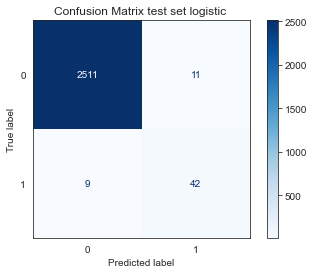

In [88]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_log,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test set logistic ')
print(disp.confusion_matrix)
plt.show()


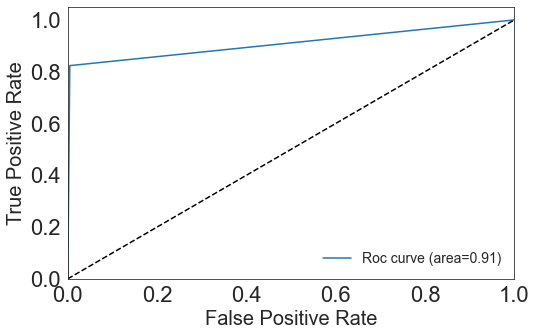

In [89]:
plt.figure(figsize=(8,5))
plt.plot(fpr_f,tpr_f,label='Roc curve (area=%0.2f)'%(roc_auc_f))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [90]:
parameters_tanh = {'solver': ['lbfgs'], 'activation':['tanh'], 'hidden_layer_sizes':np.arange(36, 68), 'alpha': 10.0 **-np.arange(0, 1) , 'learning_rate':['adaptive']}
clf_grid_tanh = GridSearchCV(neural_network.MLPClassifier(), parameters_tanh, n_jobs=-1)

In [91]:
clf_grid_tanh.fit(X_train, y_train.values.ravel())
print("-----------------Original Features--------------------")
print("Best score: %0.4f" % clf_grid_tanh.best_score_)
print("Using the following parameters:")
print(clf_grid_tanh.best_params_)


-----------------Original Features--------------------
Best score: 0.9947
Using the following parameters:
{'activation': 'tanh', 'alpha': 1.0, 'hidden_layer_sizes': 51, 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


In [92]:
y_pred_grid_tanh = clf_grid_tanh.predict(X_test)

In [93]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_grid_tanh))
print('F1-score %s' % f1_score(y_test,y_pred_grid_tanh, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9926156237854644
F1-score [0.99622642 0.82882883]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2522
           1       0.72      0.71      0.71        51

    accuracy                           0.99      2573
   macro avg       0.86      0.85      0.85      2573
weighted avg       0.99      0.99      0.99      2573



In [94]:
fpr_1,tpr_1,_=roc_curve(y_test,y_pred_grid_tanh)
roc_auc_1=auc(fpr_1,tpr_1)
print(roc_auc_1)


0.9482048172163393


[[2508   14]
 [   5   46]]


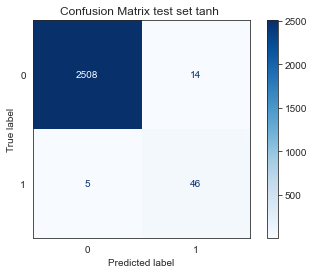

In [95]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_tanh,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test set tanh ')
print(disp.confusion_matrix)
plt.show()

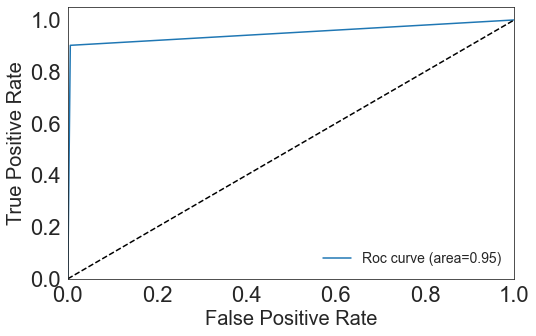

In [96]:
plt.figure(figsize=(8,5))
plt.plot(fpr_1,tpr_1,label='Roc curve (area=%0.2f)'%(roc_auc_1))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

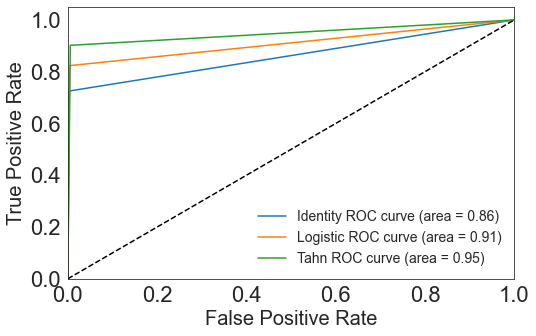

In [97]:
plt.figure(figsize=(8, 5))
plt.plot(fpr_e, tpr_e, label='Identity ROC curve (area = %0.2f)' % (roc_auc_e))
plt.plot(fpr_f, tpr_f, label='Logistic ROC curve (area = %0.2f)' % (roc_auc_f))
plt.plot(fpr_1, tpr_1, label='Tahn ROC curve (area = %0.2f)' % (roc_auc_1))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [98]:
from sklearn.metrics import classification_report

In [99]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [97]:
parameter_space = {'hidden_layer_sizes': [(10,30,10),(20,30,40)],
                   'activation': ['relu'],'solver': ['lbfgs'],
                   'learning_rate': ['adaptive'], 
                   'momentum': [0.1, 0.5, 0.7]}
clf = GridSearchCV(neural_network.MLPClassifier(), parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
print('3fold cross validation')
report(clf.cv_results_, n_top=5)
print('Best parameters found:\n', clf.best_params_)

3fold cross validation
Model with rank: 1
Mean validation score: 0.992 (std: 0.002)
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'momentum': 0.1, 'solver': 'lbfgs'}

Model with rank: 1
Mean validation score: 0.992 (std: 0.002)
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'momentum': 0.7, 'solver': 'lbfgs'}

Model with rank: 3
Mean validation score: 0.992 (std: 0.001)
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'momentum': 0.5, 'solver': 'lbfgs'}

Model with rank: 4
Mean validation score: 0.992 (std: 0.002)
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (20, 30, 40), 'learning_rate': 'adaptive', 'momentum': 0.7, 'solver': 'lbfgs'}

Model with rank: 5
Mean validation score: 0.992 (std: 0.001)
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (20, 30, 40), 'learning_rate': 'adaptive', 'momentum': 0.1, 'solver

In [187]:
parameters_grid = {'solver': ['lbfgs'], 'activation':['relu'], 'hidden_layer_sizes':[(10,30,10)], 'momentum': [0.1], 'learning_rate':['adaptive']}

clf_grid_2= GridSearchCV(neural_network.MLPClassifier(), parameters_grid, n_jobs=-1)

In [188]:
clf_grid_2.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [(10, 30, 10)],
                         'learning_rate': ['adaptive'], 'momentum': [0.1],
                         'solver': ['lbfgs']})

In [189]:
y_val_pred_2 = clf_grid_2.predict(X_val)

In [190]:
print('Accuracy %s' % accuracy_score(y_val, y_val_pred_2))
print('F1-score %s' % f1_score(y_val, y_val_pred_2, average=None))
print(classification_report(y_val, y_val_pred_2))

Accuracy 0.9852295409181637
F1-score [0.9924536  0.65420561]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2454
           1       0.62      0.69      0.65        51

    accuracy                           0.99      2505
   macro avg       0.81      0.84      0.82      2505
weighted avg       0.99      0.99      0.99      2505



In [191]:
fpr,tpr,_=roc_curve(y_val, y_val_pred_2)
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.8388585262956038


[[2433   21]
 [  16   35]]


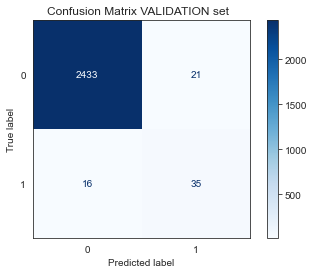

In [192]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_2,X_val, y_val,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix VALIDATION set  ')
print(disp.confusion_matrix)
plt.show()

sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_2,y_val, y_val_pred_2,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix VALIDATION set  ')
print(disp.confusion_matrix)
plt.show()

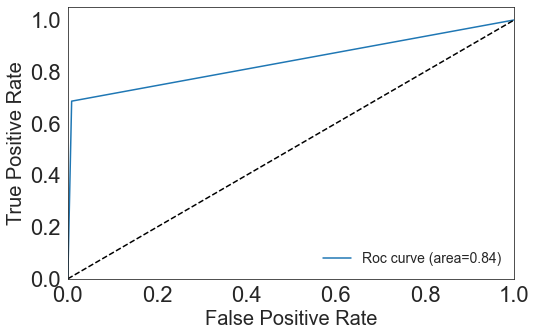

In [193]:
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [194]:
y_pred_grid_2 = clf_grid_2.predict(X_test)

In [195]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_grid_2))
print('F1-score %s' % f1_score(y_test,y_pred_grid_2, average=None))
print(classification_report(y_test, y_pred_grid_2))

Accuracy 0.9902837155071901
F1-score [0.99503476 0.77477477]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2522
           1       0.72      0.84      0.77        51

    accuracy                           0.99      2573
   macro avg       0.86      0.92      0.88      2573
weighted avg       0.99      0.99      0.99      2573



In [196]:
fpr_2,tpr_2,_=roc_curve(y_test,y_pred_grid_2)
roc_auc_2=auc(fpr_2,tpr_2)
print(roc_auc_2)

0.9181982864517735


[[2505   17]
 [   8   43]]


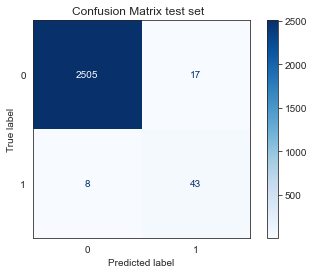

In [197]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_2,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test set  ')
print(disp.confusion_matrix)
plt.show()

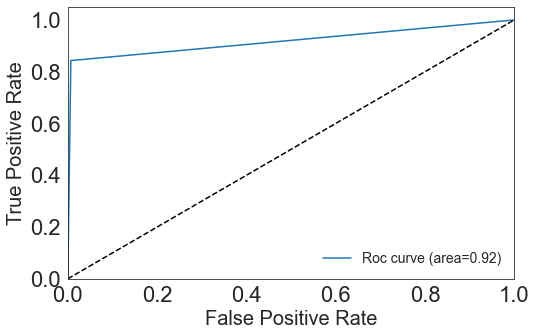

In [198]:
plt.figure(figsize=(8,5))
plt.plot(fpr_2,tpr_2,label='Roc curve (area=%0.2f)'%(roc_auc_2))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [199]:
parameter_space = {'hidden_layer_sizes': [(10,30,10),(20,30,40)],
                   'activation': ['relu'],'solver': ['lbfgs'],
                   'learning_rate': ['adaptive'], 
                   'momentum': [0.1, 0.2, 0.5, 0.7], 'early_stopping': [True]}
clf = GridSearchCV(neural_network.MLPClassifier(), parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
print('3fold cross validation')
report(clf.cv_results_, n_top=5)
print('Best parameters found:\n', clf.best_params_)

3fold cross validation
Model with rank: 1
Mean validation score: 0.993 (std: 0.001)
Parameters: {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'momentum': 0.5, 'solver': 'lbfgs'}

Model with rank: 2
Mean validation score: 0.993 (std: 0.001)
Parameters: {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (20, 30, 40), 'learning_rate': 'adaptive', 'momentum': 0.7, 'solver': 'lbfgs'}

Model with rank: 3
Mean validation score: 0.993 (std: 0.001)
Parameters: {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'momentum': 0.7, 'solver': 'lbfgs'}

Model with rank: 4
Mean validation score: 0.993 (std: 0.001)
Parameters: {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (20, 30, 40), 'learning_rate': 'adaptive', 'momentum': 0.5, 'solver': 'lbfgs'}

Model with rank: 5
Mean validation score: 0.992 (std: 0.002)
Parameters: {'activation': '

In [200]:
parameters_grid_3 = {'solver': ['lbfgs'], 'activation':['relu'], 'hidden_layer_sizes':[(10,30,10)], 'momentum': [0.5], 'learning_rate':['adaptive'], 'early_stopping': [True] }
clf_grid_3= GridSearchCV(neural_network.MLPClassifier(), parameters_grid_3, n_jobs=-1)

In [201]:
clf_grid_3.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'], 'early_stopping': [True],
                         'hidden_layer_sizes': [(10, 30, 10)],
                         'learning_rate': ['adaptive'], 'momentum': [0.5],
                         'solver': ['lbfgs']})

In [202]:
y_val_pred_3 = clf_grid_3.predict(X_val)

In [203]:
print('Accuracy %s' % accuracy_score(y_val, y_val_pred_3))
print('F1-score %s' % f1_score(y_val, y_val_pred_3, average=None))
print(classification_report(y_val, y_val_pred_3))

Accuracy 0.9840319361277445
F1-score [0.9918334  0.64285714]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2454
           1       0.59      0.71      0.64        51

    accuracy                           0.98      2505
   macro avg       0.79      0.85      0.82      2505
weighted avg       0.99      0.98      0.98      2505



In [204]:
fpr,tpr,_=roc_curve(y_val, y_val_pred_3)
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.847847451939211


[[2429   25]
 [  15   36]]


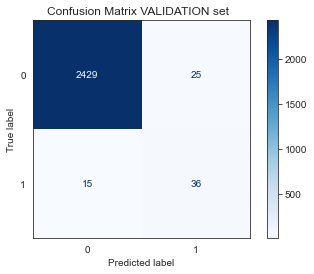

In [205]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_3,X_val, y_val,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix VALIDATION set  ')
print(disp.confusion_matrix)
plt.show()

In [206]:
y_pred_grid_3 = clf_grid_3.predict(X_test)

In [207]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_grid_3))
print('F1-score %s' % f1_score(y_test,y_pred_grid_3, average=None))
print(classification_report(y_test, y_pred_grid_3))

Accuracy 0.9871745044694908
F1-score [0.99343284 0.72727273]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2522
           1       0.63      0.86      0.73        51

    accuracy                           0.99      2573
   macro avg       0.81      0.93      0.86      2573
weighted avg       0.99      0.99      0.99      2573



In [208]:
fpr_3,tpr_3,_=roc_curve(y_test,y_pred_grid_3)
roc_auc_3=auc(fpr_3,tpr_3)
print(roc_auc_3)

0.9262179098443502


[[2496   26]
 [   7   44]]


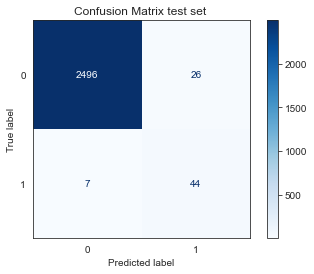

In [209]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_3,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test set ')
print(disp.confusion_matrix)
plt.show()

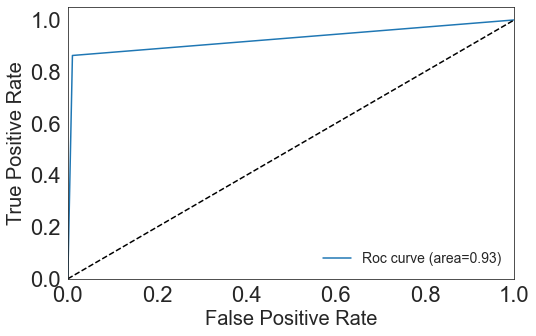

In [210]:
plt.figure(figsize=(8,5))
plt.plot(fpr_3,tpr_3,label='Roc curve (area=%0.2f)'%(roc_auc_3))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [211]:
parameter_space = {'hidden_layer_sizes': [(10,30,10),(20,30,40)],
                   'activation': ['relu'],'solver': ['lbfgs'],
                   'learning_rate': ['adaptive'], 
                   'momentum': [0.1, 0.2, 0.5, 0.7], 'early_stopping': [True], 'alpha': [0.1, 0.2, 0.5, 0.7]}
clf = GridSearchCV(neural_network.MLPClassifier(), parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
print('3fold cross validation')
report(clf.cv_results_, n_top=5)
print('Best parameters found:\n', clf.best_params_)

3fold cross validation
Model with rank: 1
Mean validation score: 0.993 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.7, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'momentum': 0.7, 'solver': 'lbfgs'}

Model with rank: 2
Mean validation score: 0.993 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.5, 'early_stopping': True, 'hidden_layer_sizes': (20, 30, 40), 'learning_rate': 'adaptive', 'momentum': 0.1, 'solver': 'lbfgs'}

Model with rank: 3
Mean validation score: 0.993 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.5, 'early_stopping': True, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'momentum': 0.2, 'solver': 'lbfgs'}

Model with rank: 4
Mean validation score: 0.993 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.5, 'early_stopping': True, 'hidden_layer_sizes': (20, 30, 40), 'learning_rate': 'adaptive', 'momentum': 0.2, 'solver': 'lbfgs'}

Model with rank: 5
Mean validatio

In [225]:
parameters_grid_4 = {'solver': ['lbfgs'], 'activation':['relu'], 'hidden_layer_sizes':[(10, 30, 10)], 'momentum': [0.7], 'learning_rate':['adaptive'], 'early_stopping': [True], 'alpha':[0.7] }
clf_grid_4= GridSearchCV(neural_network.MLPClassifier(), parameters_grid_4, n_jobs=-1)

In [226]:
clf_grid_4.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.7],
                         'early_stopping': [True],
                         'hidden_layer_sizes': [(10, 30, 10)],
                         'learning_rate': ['adaptive'], 'momentum': [0.7],
                         'solver': ['lbfgs']})

In [227]:
y_val_pred_4 = clf_grid_4.predict(X_val)

In [228]:
print('Accuracy %s' % accuracy_score(y_val, y_val_pred_4))
print('F1-score %s' % f1_score(y_val, y_val_pred_4, average=None))
print(classification_report(y_val, y_val_pred_4))

Accuracy 0.9860279441117764
F1-score [0.99286151 0.6728972 ]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2454
           1       0.64      0.71      0.67        51

    accuracy                           0.99      2505
   macro avg       0.82      0.85      0.83      2505
weighted avg       0.99      0.99      0.99      2505



In [229]:
fpr,tpr,_=roc_curve(y_val, y_val_pred_4)
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.8488661968454864


[[2434   20]
 [  15   36]]


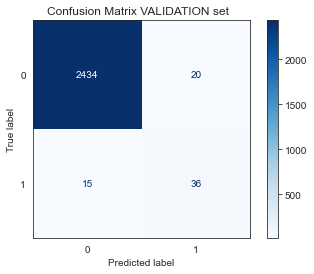

In [230]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_4,X_val, y_val,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix VALIDATION set  ')
print(disp.confusion_matrix)
plt.show()

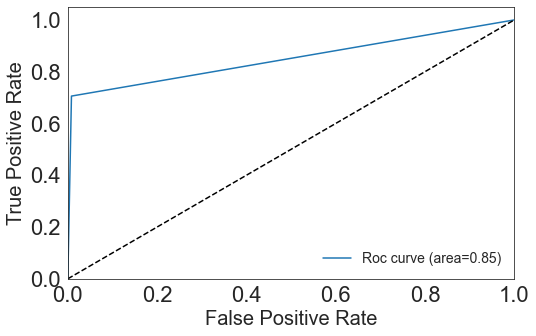

In [231]:
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [232]:
y_pred_grid_4 = clf_grid_4.predict(X_test)

In [233]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_grid_4))
print('F1-score %s' % f1_score(y_test,y_pred_grid_4, average=None))
print(classification_report(y_test, y_pred_grid_4))

Accuracy 0.9902837155071901
F1-score [0.99503081 0.7826087 ]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2522
           1       0.70      0.88      0.78        51

    accuracy                           0.99      2573
   macro avg       0.85      0.94      0.89      2573
weighted avg       0.99      0.99      0.99      2573



In [234]:
fpr_4,tpr_4,_=roc_curve(y_test,y_pred_grid_4)
roc_auc_4=auc(fpr_4,tpr_4)
print(roc_auc_4)

0.9374096188832393


[[2503   19]
 [   6   45]]


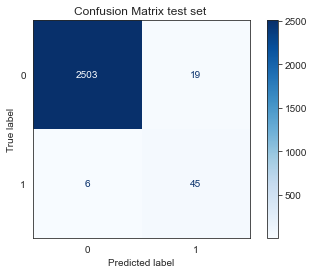

In [235]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_4,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test set ')
print(disp.confusion_matrix)
plt.show()

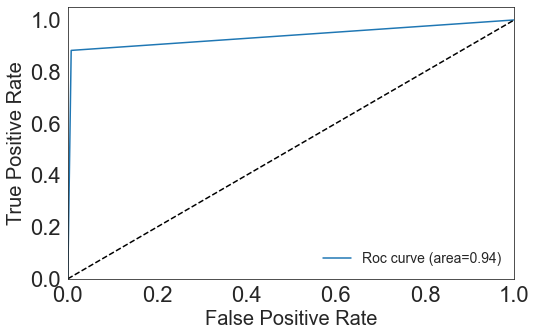

In [236]:
plt.figure(figsize=(8,5))
plt.plot(fpr_4,tpr_4,label='Roc curve (area=%0.2f)'%(roc_auc_4))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [237]:
parameter_space = {'hidden_layer_sizes': [(10,30,10),(20,30,40), (6,12,24)],
                   'activation': ['relu'],'solver': ['lbfgs'],
                   'learning_rate': ['adaptive'], 
                   'momentum': [0.1, 0.2, 0.5, 0.7, 1], 'early_stopping': [True], 'alpha': [0.1, 0.2, 0.5, 0.7, 1]}
clf = GridSearchCV(neural_network.MLPClassifier(), parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
print('3fold cross validation')
report(clf.cv_results_, n_top=5)
print('Best parameters found:\n', clf.best_params_)

3fold cross validation
Model with rank: 1
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.5, 'early_stopping': True, 'hidden_layer_sizes': (6, 12, 24), 'learning_rate': 'adaptive', 'momentum': 0.2, 'solver': 'lbfgs'}

Model with rank: 2
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (6, 12, 24), 'learning_rate': 'adaptive', 'momentum': 0.5, 'solver': 'lbfgs'}

Model with rank: 2
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 1, 'early_stopping': True, 'hidden_layer_sizes': (6, 12, 24), 'learning_rate': 'adaptive', 'momentum': 1, 'solver': 'lbfgs'}

Model with rank: 4
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 1, 'early_stopping': True, 'hidden_layer_sizes': (6, 12, 24), 'learning_rate': 'adaptive', 'momentum': 0.7, 'solver': 'lbfgs'}

Model with rank: 5
Mean validation score: 0

In [238]:
parameters_grid_5 = {'solver': ['lbfgs'], 'activation':['relu'], 'hidden_layer_sizes':[(6,12,24)], 'momentum': [0.2], 'learning_rate':['adaptive'], 'early_stopping': [True], 'alpha':[0.5] }
clf_grid_5= GridSearchCV(neural_network.MLPClassifier(), parameters_grid_5, n_jobs=-1)

In [239]:
clf_grid_5.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.5],
                         'early_stopping': [True],
                         'hidden_layer_sizes': [(6, 12, 24)],
                         'learning_rate': ['adaptive'], 'momentum': [0.2],
                         'solver': ['lbfgs']})

In [240]:
y_val_pred_5 = clf_grid_5.predict(X_val)

In [241]:
print('Accuracy %s' % accuracy_score(y_val, y_val_pred_5))
print('F1-score %s' % f1_score(y_val, y_val_pred_5, average=None))
print(classification_report(y_val, y_val_pred_5))

Accuracy 0.9860279441117764
F1-score [0.99286151 0.6728972 ]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2454
           1       0.64      0.71      0.67        51

    accuracy                           0.99      2505
   macro avg       0.82      0.85      0.83      2505
weighted avg       0.99      0.99      0.99      2505



In [242]:
fpr,tpr,_=roc_curve(y_val, y_val_pred_5)
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.8488661968454864


[[2434   20]
 [  15   36]]


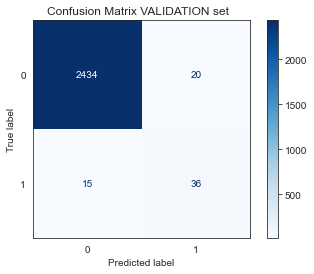

In [243]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_5,X_val, y_val,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix VALIDATION set  ')
print(disp.confusion_matrix)
plt.show()

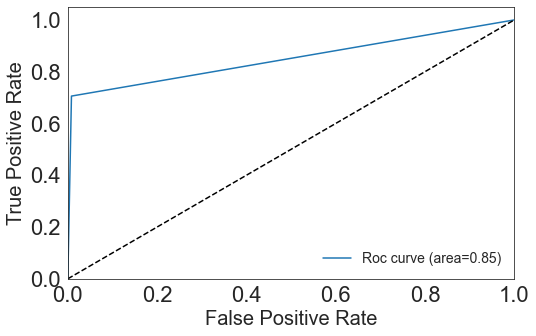

In [244]:
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [245]:
y_pred_grid_5 = clf_grid_5.predict(X_test)

In [246]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_grid_5))
print('F1-score %s' % f1_score(y_test,y_pred_grid_5, average=None))
print(classification_report(y_test, y_pred_grid_5))

Accuracy 0.9914496696463272
F1-score [0.99562798 0.80701754]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2522
           1       0.73      0.90      0.81        51

    accuracy                           0.99      2573
   macro avg       0.86      0.95      0.90      2573
weighted avg       0.99      0.99      0.99      2573



In [247]:
fpr_5,tpr_5,_=roc_curve(y_test,y_pred_grid_5)
roc_auc_5=auc(fpr_5,tpr_5)
print(roc_auc_5)

0.9476100511576557


[[2505   17]
 [   5   46]]


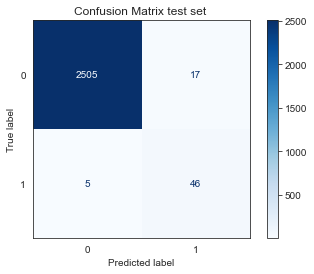

In [248]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_5,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test set ')
print(disp.confusion_matrix)
plt.show()

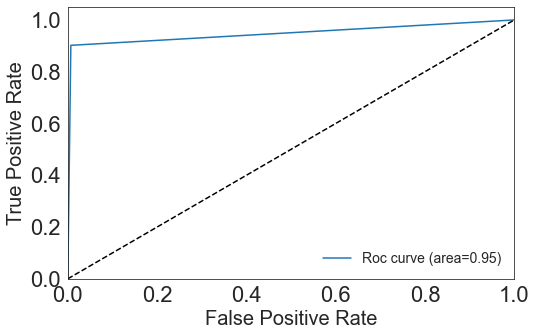

In [249]:
plt.figure(figsize=(8,5))
plt.plot(fpr_5,tpr_5,label='Roc curve (area=%0.2f)'%(roc_auc_5))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [250]:
parameter_space = {'hidden_layer_sizes': [(24,12,6), (6,12,24)],
                   'activation': ['relu'],'solver': ['lbfgs'],
                   'learning_rate': ['adaptive'], 
                   'momentum': [0.1, 0.2, 0.5, 0.7, 1], 'early_stopping': [True], 'alpha': [0.1, 0.2, 0.5, 0.7, 1]}
clf = GridSearchCV(neural_network.MLPClassifier(), parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
print('3fold cross validation')
report(clf.cv_results_, n_top=5)
print('Best parameters found:\n', clf.best_params_)

3fold cross validation
Model with rank: 1
Mean validation score: 0.994 (std: 0.000)
Parameters: {'activation': 'relu', 'alpha': 0.7, 'early_stopping': True, 'hidden_layer_sizes': (6, 12, 24), 'learning_rate': 'adaptive', 'momentum': 0.7, 'solver': 'lbfgs'}

Model with rank: 2
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 1, 'early_stopping': True, 'hidden_layer_sizes': (6, 12, 24), 'learning_rate': 'adaptive', 'momentum': 0.2, 'solver': 'lbfgs'}

Model with rank: 3
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (6, 12, 24), 'learning_rate': 'adaptive', 'momentum': 0.1, 'solver': 'lbfgs'}

Model with rank: 4
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.2, 'early_stopping': True, 'hidden_layer_sizes': (6, 12, 24), 'learning_rate': 'adaptive', 'momentum': 0.2, 'solver': 'lbfgs'}

Model with rank: 5
Mean validation scor

In [251]:
parameters_grid_6 = {'solver': ['lbfgs'], 'activation':['relu'], 'hidden_layer_sizes':[(6,12,24)], 'momentum': [0.7], 'learning_rate':['adaptive'], 'early_stopping': [True], 'alpha':[0.7] }
clf_grid_6= GridSearchCV(neural_network.MLPClassifier(), parameters_grid_6, n_jobs=-1)

In [252]:
clf_grid_6.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.7],
                         'early_stopping': [True],
                         'hidden_layer_sizes': [(6, 12, 24)],
                         'learning_rate': ['adaptive'], 'momentum': [0.7],
                         'solver': ['lbfgs']})

In [253]:
y_val_pred_6 = clf_grid_6.predict(X_val)

In [254]:
print('Accuracy %s' % accuracy_score(y_val, y_val_pred_6))
print('F1-score %s' % f1_score(y_val, y_val_pred_6, average=None))
print(classification_report(y_val, y_val_pred_6))

Accuracy 0.9864271457085828
F1-score [0.99306971 0.67307692]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2454
           1       0.66      0.69      0.67        51

    accuracy                           0.99      2505
   macro avg       0.83      0.84      0.83      2505
weighted avg       0.99      0.99      0.99      2505



In [255]:
fpr,tpr,_=roc_curve(y_val, y_val_pred_6)
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.8394697732393692


[[2436   18]
 [  16   35]]


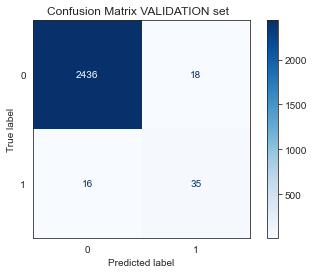

In [256]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_6,X_val, y_val,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix VALIDATION set  ')
print(disp.confusion_matrix)
plt.show()

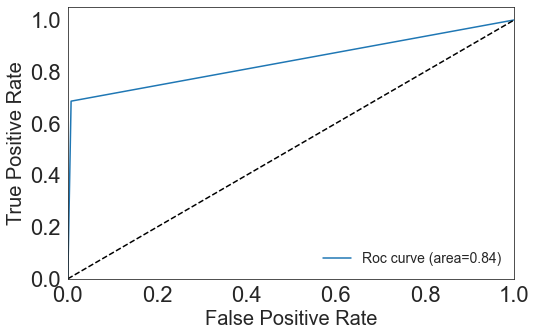

In [257]:
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [258]:
y_pred_grid_6 = clf_grid_6.predict(X_test)

In [259]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_grid_6))
print('F1-score %s' % f1_score(y_test,y_pred_grid_6, average=None))
print(classification_report(y_test, y_pred_grid_6))

Accuracy 0.9930042751651769
F1-score [0.99642715 0.83333333]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2522
           1       0.79      0.88      0.83        51

    accuracy                           0.99      2573
   macro avg       0.89      0.94      0.91      2573
weighted avg       0.99      0.99      0.99      2573



In [260]:
fpr_6,tpr_6,_=roc_curve(y_test,y_pred_grid_6)
roc_auc_6=auc(fpr_6,tpr_6)
print(roc_auc_6)

0.938797406353501


[[2510   12]
 [   6   45]]


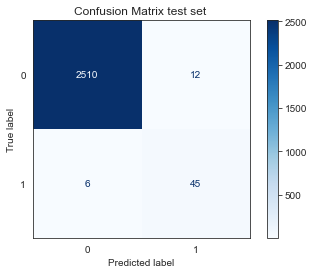

In [261]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_6,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test set ')
print(disp.confusion_matrix)
plt.show()

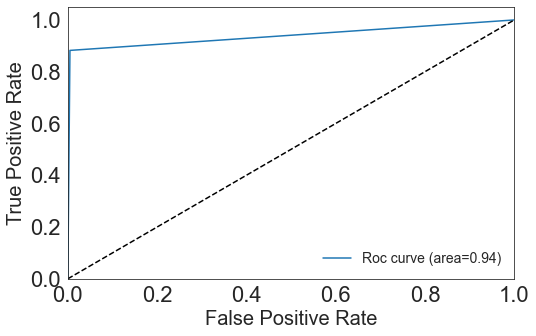

In [262]:
plt.figure(figsize=(8,5))
plt.plot(fpr_6,tpr_6,label='Roc curve (area=%0.2f)'%(roc_auc_6))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [263]:
parameter_space = {'hidden_layer_sizes': [(12,24,6), (6,12,24), (6,24,12)],
                   'activation': ['relu'],'solver': ['lbfgs'],
                   'learning_rate': ['adaptive'], 
                   'momentum': [0.1, 0.2, 0.5, 0.7, 1], 'early_stopping': [True], 'alpha': [0.1, 0.2, 0.5, 0.7, 1]}
clf = GridSearchCV(neural_network.MLPClassifier(), parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
print('3fold cross validation')
report(clf.cv_results_, n_top=5)
print('Best parameters found:\n', clf.best_params_)

3fold cross validation
Model with rank: 1
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.5, 'early_stopping': True, 'hidden_layer_sizes': (6, 24, 12), 'learning_rate': 'adaptive', 'momentum': 1, 'solver': 'lbfgs'}

Model with rank: 2
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.7, 'early_stopping': True, 'hidden_layer_sizes': (6, 12, 24), 'learning_rate': 'adaptive', 'momentum': 0.2, 'solver': 'lbfgs'}

Model with rank: 3
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.5, 'early_stopping': True, 'hidden_layer_sizes': (6, 24, 12), 'learning_rate': 'adaptive', 'momentum': 0.1, 'solver': 'lbfgs'}

Model with rank: 4
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 1, 'early_stopping': True, 'hidden_layer_sizes': (6, 12, 24), 'learning_rate': 'adaptive', 'momentum': 0.1, 'solver': 'lbfgs'}

Model with rank: 4
Mean validation score:

In [264]:
parameters_grid_7 = {'solver': ['lbfgs'], 'activation':['relu'], 'hidden_layer_sizes':[(6,24,12)], 'momentum': [1], 'learning_rate':['adaptive'], 'early_stopping': [True], 'alpha':[0.5] }
clf_grid_7= GridSearchCV(neural_network.MLPClassifier(), parameters_grid_7, n_jobs=-1)

In [265]:
clf_grid_7.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.5],
                         'early_stopping': [True],
                         'hidden_layer_sizes': [(6, 24, 12)],
                         'learning_rate': ['adaptive'], 'momentum': [1],
                         'solver': ['lbfgs']})

In [266]:
y_val_pred_7 = clf_grid_7.predict(X_val)

In [267]:
print('Accuracy %s' % accuracy_score(y_val, y_val_pred_7))
print('F1-score %s' % f1_score(y_val, y_val_pred_7, average=None))
print(classification_report(y_val, y_val_pred_7))

Accuracy 0.9864271457085828
F1-score [0.99307253 0.66666667]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2454
           1       0.67      0.67      0.67        51

    accuracy                           0.99      2505
   macro avg       0.83      0.83      0.83      2505
weighted avg       0.99      0.99      0.99      2505



In [268]:
fpr,tpr,_=roc_curve(y_val, y_val_pred_7)
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.8298696006519967


[[2437   17]
 [  17   34]]


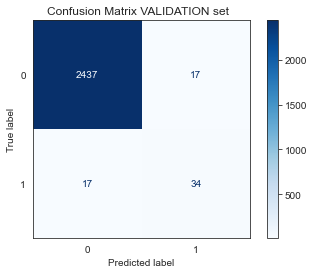

In [269]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_7,X_val, y_val,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix VALIDATION set  ')
print(disp.confusion_matrix)
plt.show()

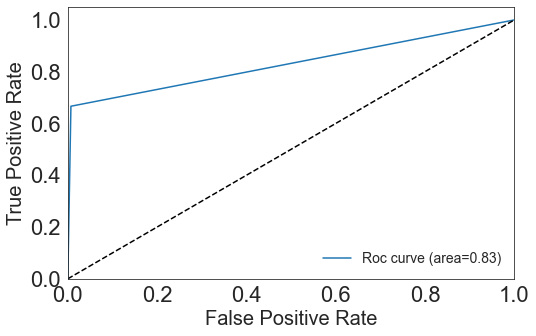

In [270]:
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [271]:
y_pred_grid_7 = clf_grid_7.predict(X_test)

In [272]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_grid_7))
print('F1-score %s' % f1_score(y_test,y_pred_grid_7, average=None))
print(classification_report(y_test, y_pred_grid_7))

Accuracy 0.9906723668869024
F1-score [0.9952362  0.77777778]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2522
           1       0.74      0.82      0.78        51

    accuracy                           0.99      2573
   macro avg       0.87      0.91      0.89      2573
weighted avg       0.99      0.99      0.99      2573



In [273]:
fpr_7,tpr_7,_=roc_curve(y_test,y_pred_grid_7)
roc_auc_7=auc(fpr_7,tpr_7)
print(roc_auc_7)

0.908790875588935


[[2507   15]
 [   9   42]]


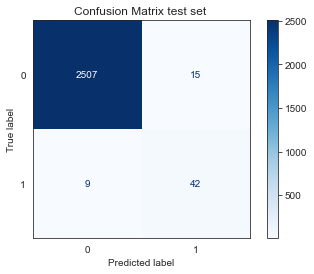

In [274]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_7,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test set ')
print(disp.confusion_matrix)
plt.show()

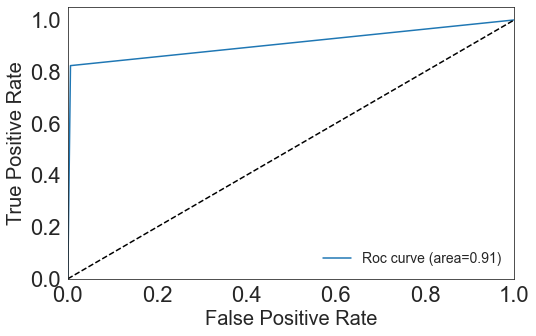

In [275]:
plt.figure(figsize=(8,5))
plt.plot(fpr_7,tpr_7,label='Roc curve (area=%0.2f)'%(roc_auc_7))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [276]:
parameter_space = {'hidden_layer_sizes': [(12,24,6), (6,12,24), (6,24,12)],
                   'activation': ['relu'],'solver': ['lbfgs'],
                   'learning_rate': ['adaptive'], 
                   'momentum': [ 0.7, 0.8, 0.9], 'early_stopping': [True], 'alpha': [0.1, 0.2, 0.5, 0.8, 0.9]}
clf = GridSearchCV(neural_network.MLPClassifier(), parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
print('3fold cross validation')
report(clf.cv_results_, n_top=5)
print('Best parameters found:\n', clf.best_params_)

3fold cross validation
Model with rank: 1
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.8, 'early_stopping': True, 'hidden_layer_sizes': (6, 12, 24), 'learning_rate': 'adaptive', 'momentum': 0.8, 'solver': 'lbfgs'}

Model with rank: 2
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.5, 'early_stopping': True, 'hidden_layer_sizes': (6, 12, 24), 'learning_rate': 'adaptive', 'momentum': 0.7, 'solver': 'lbfgs'}

Model with rank: 3
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.9, 'early_stopping': True, 'hidden_layer_sizes': (12, 24, 6), 'learning_rate': 'adaptive', 'momentum': 0.7, 'solver': 'lbfgs'}

Model with rank: 3
Mean validation score: 0.994 (std: 0.001)
Parameters: {'activation': 'relu', 'alpha': 0.9, 'early_stopping': True, 'hidden_layer_sizes': (6, 24, 12), 'learning_rate': 'adaptive', 'momentum': 0.9, 'solver': 'lbfgs'}

Model with rank: 5
Mean validation sc

In [46]:
parameters_grid_8 = {'solver': ['lbfgs'], 'activation':['relu'], 'hidden_layer_sizes':[(12, 24, 6)], 'momentum': [0.8], 'learning_rate':['adaptive'], 'early_stopping': [True], 'alpha':[0.8] }
clf_grid_8= GridSearchCV(neural_network.MLPClassifier(), parameters_grid_8, n_jobs=-1)

In [47]:
clf_grid_8.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.8],
                         'early_stopping': [True],
                         'hidden_layer_sizes': [(12, 24, 6)],
                         'learning_rate': ['adaptive'], 'momentum': [0.8],
                         'solver': ['lbfgs']})

In [48]:
y_val_pred_8 = clf_grid_8.predict(X_val)

In [49]:
print('Accuracy %s' % accuracy_score(y_val_pred_8, y_val))
print('F1-score %s' % f1_score(y_val_pred_8, y_val, average=None))
print(classification_report(y_val_pred_8, y_val))

Accuracy 0.9880239520958084
F1-score [0.99388753 0.70588235]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2454
           1       0.71      0.71      0.71        51

    accuracy                           0.99      2505
   macro avg       0.85      0.85      0.85      2505
weighted avg       0.99      0.99      0.99      2505



In [50]:
fpr,tpr,_=roc_curve(y_val, y_val_pred_8)
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.8498849417517619


[[2439   15]
 [  15   36]]


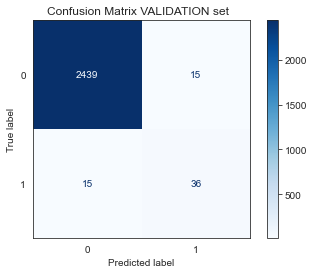

In [51]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_8,X_val, y_val,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix VALIDATION set  ')
print(disp.confusion_matrix)
plt.show()

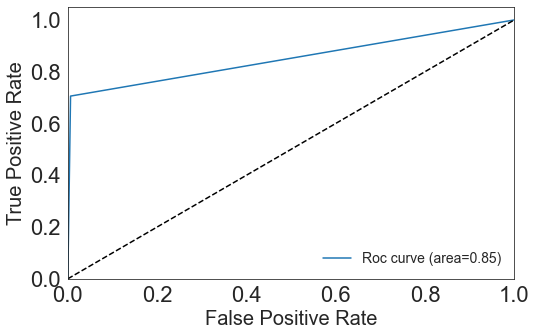

In [52]:
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [53]:
y_pred_grid_8 = clf_grid_8.predict(X_test)

In [54]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_grid_8))
print('F1-score %s' % f1_score(y_test,y_pred_grid_8, average=None))
print(classification_report(y_test, y_pred_grid_8))

Accuracy 0.9922269724057521
F1-score [0.99602859 0.81818182]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2522
           1       0.76      0.88      0.82        51

    accuracy                           0.99      2573
   macro avg       0.88      0.94      0.91      2573
weighted avg       0.99      0.99      0.99      2573



In [55]:
fpr_8,tpr_8,_=roc_curve(y_test,y_pred_grid_8)
roc_auc_8=auc(fpr_8,tpr_8)
print(roc_auc_8)

0.9384008956477119


[[2508   14]
 [   6   45]]


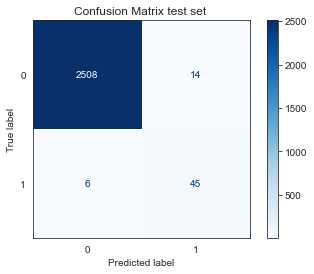

In [56]:
sns.set_style('white')

disp = plot_confusion_matrix(clf_grid_8,X_test,y_test,
                            cmap = plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix test set ')
print(disp.confusion_matrix)
plt.show()

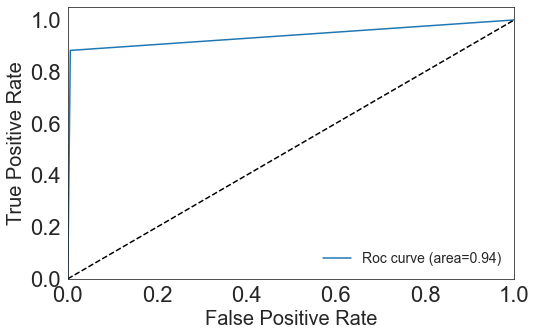

In [57]:
plt.figure(figsize=(8,5))
plt.plot(fpr_8,tpr_8,label='Roc curve (area=%0.2f)'%(roc_auc_8))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

# Random oversampling

In [58]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

In [59]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 18808, 1: 18808})


In [60]:
clf_grid_8.fit(X_res, y_res)

y_pred_random= clf_grid_8.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_random))
print('F1-score %s' % f1_score(y_test, y_pred_random, average=None))
print(classification_report(y_test, y_pred_random))
print(confusion_matrix(y_test,y_pred_random))

Accuracy 0.9700738437621453
F1-score [0.98450392 0.56497175]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2522
           1       0.40      0.98      0.56        51

    accuracy                           0.97      2573
   macro avg       0.70      0.98      0.77      2573
weighted avg       0.99      0.97      0.98      2573

[[2446   76]
 [   1   50]]


In [69]:
fpr_random,tpr_random,_=roc_curve(y_test,y_pred_random)
roc_auc_random=auc(fpr_random,tpr_random)
print(roc_auc_random)

0.9751286716113884


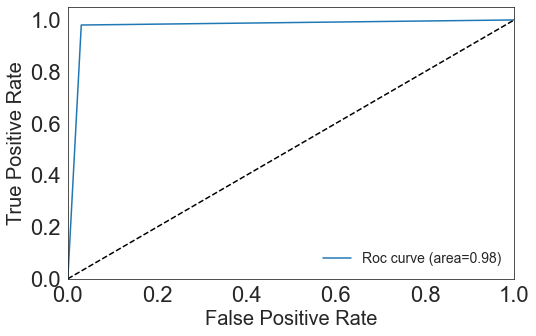

In [71]:
plt.figure(figsize=(8,5))
plt.plot(fpr_random,tpr_random,label='Roc curve (area=%0.2f)'%(roc_auc_random))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

# Condensed nearest neighbor

In [63]:
from imblearn.under_sampling import CondensedNearestNeighbour

In [64]:
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res_cnn, y_res_cnn = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res_cnn))

Resampled dataset shape Counter({0: 568, 1: 371})


In [65]:
clf_grid_8.fit(X_res_cnn, y_res_cnn)

dt_pred_cnn = clf_grid_8.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, dt_pred_cnn))
print('F1-score %s' % f1_score(y_test, dt_pred_cnn, average=None))
print(classification_report(y_test, dt_pred_cnn))
print(confusion_matrix(y_test,dt_pred_cnn))

Accuracy 0.9832879906723669
F1-score [0.99141545 0.68613139]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2522
           1       0.55      0.92      0.69        51

    accuracy                           0.98      2573
   macro avg       0.77      0.95      0.84      2573
weighted avg       0.99      0.98      0.99      2573

[[2483   39]
 [   4   47]]


In [66]:
fpr_cnn,tpr_cnn,_=roc_curve(y_test,dt_pred_cnn)
roc_auc_cnn=auc(fpr_cnn,tpr_cnn)
print(roc_auc_cnn)

0.9530523549626035


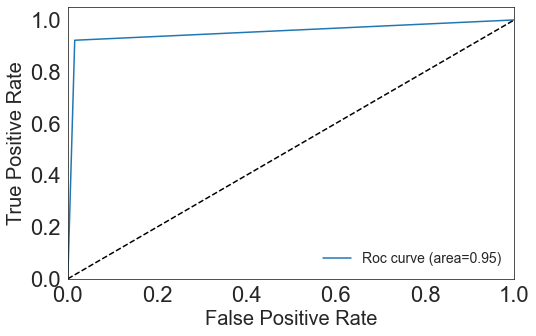

In [67]:
plt.figure(figsize=(8,5))
plt.plot(fpr_cnn,tpr_cnn,label='Roc curve (area=%0.2f)'%(roc_auc_cnn))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

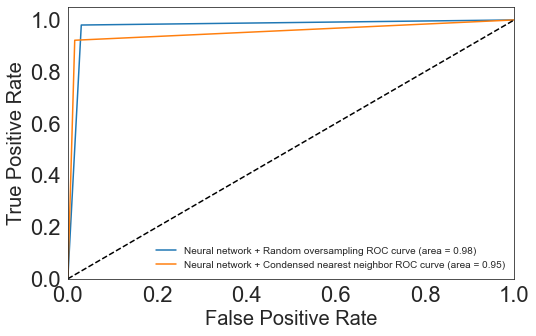

In [70]:
plt.figure(figsize=(8, 5))
plt.plot(fpr_random, tpr_random, label='Neural network + Random oversampling ROC curve (area = %0.2f)' % (roc_auc_random))
plt.plot(fpr_cnn, tpr_cnn, label='Neural network + Condensed nearest neighbor ROC curve (area = %0.2f)' % (roc_auc_cnn))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.show()